## DeepAnT Implementation for Caterpillar IoT Machine Learning Challenge

Model derived from: 

M. Munir, S. A. Siddiqui, A. Dengel and S. Ahmed, "DeepAnT: A Deep Learning Approach for Unsupervised Anomaly Detection in Time Series," 

https://ieeexplore.ieee.org/document/8581424


Implementation derived from:

https://github.com/ZhouYuxuanYX/Unsupervised-Deep-Learning-Framework-for-Anomaly-Detection-in-Time-Series-
https://github.com/hendrycks/outlier-exposure
https://github.com/swlee23/Deep-Learning-Time-Series-Anaomaly-Detection

In [261]:
import random
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD

from hdf_helper import *
from stat_helper import *
from data_cleaning import *

In [262]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [280]:
# HYPERPARAMETERS FOR OUR MODEL
w = 17280                 # History window (Based off frequency and start/end time of timeseries)   
p_w = 1000                # Prediction window (number of time stamps that we want to predict)
n_features = 1            # Univariate time series (1D Array)

kernel_size = 2          # Size of filter in convolutional layer
num_filt_1 = 32          # Number of filters in first convolutional layer
num_filt_2 = 32          # Number of filters in second convolutional layer
num_nrn_dl = 40          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer

conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

epochs = 30
dropout_rate = 0.5       # Dropout rate in the fully connected layer
learning_rate = 2e-5  
anm_det_thr = 0.8        # Threshold for classifying anomaly (0.5~0.8)

decay = 1e-6             # SGD Parameters
momentum = 0.9

In [299]:
# Read in file
filename = 'dat_ch_3'
path = 'dat/' + filename + '.csv'

# Removing all columns that aren't float64 in order to read the dataframe properly
df_test = pd.read_csv(path, nrows=100)
float_cols = [c for i, c in enumerate(df_test.columns) if i != 0]
float64_cols = {c: np.float64 for c in float_cols}
df = pd.read_csv(path, engine='c', dtype=float64_cols).drop(['Unnamed: 0'], axis = 1)

# Replace NaN values with 0
df = df.replace(np.NAN, 0.0)

# Remove all timeseries that are completely zero as to not throw off the model
zero_outliers = df.loc[:, (df == 0.0).all(axis=0)]
reg_data = df.loc[:,(df != 0.0).any(axis=0)]

In [ ]:
"""
Data preprocessing

1. Downsample data using the mean of moving windws of size 50
2. Use Gaussian blur to smooth out values
3. Scale values based on IQR (robust scaler) to make them more workable with

"""

df = reduce_dataset_size(df, cluster_size = 50)
df = smooth_values(df)

scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df))

# Subtract prediction window so we don't predict something we already know
w = len(df.index) - p_w

In [301]:
'''
Split our univariate sequence into samples
'''
def split_sequence(sequence):
    X = []
    y = []
    
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + w
        out_end_ix = end_ix + p_w
        
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [302]:
# Defining the input sequence
samples = []
labels = []

# For every timeseries, append the split univeriate sequence to our batch_sample
for i in range(len(reg_data.columns)):
    batch_sample, batch_label = split_sequence(list(reg_data.ix[:,i]))
    samples.append(batch_sample)
    labels.append(batch_label)
    
batch_samples = np.array(samples)
batch_labels = np.array(labels)



# We need to convert batch sample into 3D tensor because we are using multiple time series
# batch_sample takes the form of [batch_size, input_seq_len, n_features]
# batch_label takes the form of [number_batches, n_features, window_size]
batch_sample = batch_sample.reshape((batch_sample.shape[0], batch_sample.shape[2], n_features))
batch_label = batch_label.reshape((batch_label.shape[0],batch_label.shape[1],batch_label.shape[2]))


(27, 1, 16280)


C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [1]:
"""
Determins whether a sequence exceeds the threshold for being an anomaly

return boolean value of whether the sequence is an anomaly or not
"""
def anomaly_detector(prediction_seq, ground_truth_seq):
    # calculate Euclidean between actual seq and predicted seq
    dist = np.linalg.norm(ground_truth_seq - prediction_seq)  
    if (dist > anm_det_thr):
        return true  # anomaly
    else:
        return false # normal 


In [304]:
''' Generate Model for Predictor '''
model = Sequential()

# Convolutional Layer #1
# Computes 32 features using a 1D filter(kernel) of with w with ReLU activation. 
# Padding is added to preserve width.
# Input Tensor Shape: [batch_size, w, 1] / batch_size = len(batch_sample)
# Output Tensor Shape: [batch_size, w, num_filt_1] (num_filt_1 = 32 feature vectors)
model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

# Pooling Layer #1
# First max pooling layer with a filter of length 2 and stride of 2
# Input Tensor Shape: [batch_size, w, num_filt_1]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1]

model.add(MaxPooling1D(pool_size=pool_size_1)) 
                    #  strides=pool_strides_1, 
                    #  padding='valid'))

# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
# Padding is added to preserve width and height.
# Input Tensor Shape: [batch_size, 0.5 * w, 32]
# Output Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

# Max Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
# Input Tensor Shape: [batch_size, 0.5 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
model.add(MaxPooling1D(pool_size=pool_size_2))
                    #  strides=pool_strides_2, 
                    #  padding='valid'
          
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 0.25 * w, num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
model.add(Flatten())

# Dense Layer (Output layer)
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 0.25 * w * num_filt_1 * num_filt_2]
# Output Tensor Shape: [batch_size, 1024]
model.add(Dense(units=num_nrn_dl, activation='relu'))  

# Dropout
# Prevents overfitting in deep neural networks
model.add(Dropout(dropout_rate))

# Output layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, p_w]
model.add(Dense(units=num_nrn_ol))

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 16279, 32)         96        
_________________________________________________________________
max_pooling1d_76 (MaxPooling (None, 8139, 32)          0         
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 8138, 32)          2080      
_________________________________________________________________
max_pooling1d_77 (MaxPooling (None, 4069, 32)          0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 130208)            0         
_________________________________________________________________
dense_76 (Dense)             (None, 40)                5208360   
_________________________________________________________________
dropout_38 (Dropout)         (None, 40)              

In [ ]:
# Summarize model structure
model.summary()

In [305]:
''' Compile our model'''
model.compile(optimizer='adam', loss='mean_absolute_error')

''' The paper talks about using stochastic gradient descent to optimize our parameters '''
# sgd = keras.optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
# model.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['accuracy'])

In [307]:
''' Training our model with multiple timeseries'''

for i in range(len(reg_data.columns)):
    sample = batch_sample[i].reshape((1,batch_sample.shape[1],batch_sample.shape[2]))
    label = batch_label[i].reshape((batch_label.shape[1],batch_label.shape[2]))
    
    model.fit(sample, label, epochs=epochs, verbose=1)

(1, 16280, 1)
Epoch 1/30
1/1 [==============================] - 1s 872ms/step - loss: 0.1153
Epoch 2/30
1/1 [==============================] - 0s 58ms/step - loss: 0.1351
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 0.1816
Epoch 4/30
1/1 [==============================] - 0s 58ms/step - loss: 0.0931
Epoch 5/30
1/1 [==============================] - 0s 67ms/step - loss: 0.0019
Epoch 6/30
1/1 [==============================] - 0s 63ms/step - loss: 0.0020
Epoch 7/30
1/1 [==============================] - 0s 80ms/step - loss: 0.0019
Epoch 8/30
1/1 [==============================] - 0s 72ms/step - loss: 0.0400
Epoch 9/30
1/1 [==============================] - 0s 75ms/step - loss: 0.0018
Epoch 10/30
1/1 [==============================] - 0s 72ms/step - loss: 0.0014
Epoch 11/30
1/1 [==============================] - 0s 60ms/step - loss: 0.0013
Epoch 12/30
1/1 [==============================] - 0s 63ms/step - loss: 0.0012
Epoch 13/30
1/1 [=============================

Epoch 11/30
1/1 [==============================] - 0s 62ms/step - loss: 2.6741e-04
Epoch 12/30
1/1 [==============================] - 0s 66ms/step - loss: 2.4317e-04
Epoch 13/30
1/1 [==============================] - 0s 75ms/step - loss: 2.3924e-04
Epoch 14/30
1/1 [==============================] - 0s 67ms/step - loss: 2.4364e-04
Epoch 15/30
1/1 [==============================] - 0s 109ms/step - loss: 2.4265e-04
Epoch 16/30
1/1 [==============================] - 0s 63ms/step - loss: 2.3293e-04
Epoch 17/30
1/1 [==============================] - 0s 83ms/step - loss: 2.1663e-04
Epoch 18/30
1/1 [==============================] - 0s 68ms/step - loss: 2.0986e-04
Epoch 19/30
1/1 [==============================] - 0s 61ms/step - loss: 1.9802e-04
Epoch 20/30
1/1 [==============================] - 0s 62ms/step - loss: 1.9003e-04
Epoch 21/30
1/1 [==============================] - 0s 83ms/step - loss: 1.8494e-04
Epoch 22/30
1/1 [==============================] - 0s 56ms/step - loss: 1.7944e-04
Epo

Epoch 21/30
1/1 [==============================] - 0s 57ms/step - loss: 0.2535
Epoch 22/30
1/1 [==============================] - 0s 57ms/step - loss: 0.2535
Epoch 23/30
1/1 [==============================] - 0s 51ms/step - loss: 0.2535
Epoch 24/30
1/1 [==============================] - 0s 55ms/step - loss: 0.2535
Epoch 25/30
1/1 [==============================] - 0s 54ms/step - loss: 0.2535
Epoch 26/30
1/1 [==============================] - 0s 69ms/step - loss: 0.2535
Epoch 27/30
1/1 [==============================] - 0s 65ms/step - loss: 0.2535
Epoch 28/30
1/1 [==============================] - 0s 55ms/step - loss: 0.2535
Epoch 29/30
1/1 [==============================] - 0s 62ms/step - loss: 0.2535
Epoch 30/30
1/1 [==============================] - 0s 57ms/step - loss: 0.2535
(1, 16280, 1)
Epoch 1/30
1/1 [==============================] - 0s 53ms/step - loss: 7.6887
Epoch 2/30
1/1 [==============================] - 0s 66ms/step - loss: 7.7173
Epoch 3/30
1/1 [========================

Epoch 3/30
1/1 [==============================] - 0s 66ms/step - loss: 2.5573e-04
Epoch 4/30
1/1 [==============================] - 0s 57ms/step - loss: 2.3218e-04
Epoch 5/30
1/1 [==============================] - 0s 51ms/step - loss: 2.0934e-04
Epoch 6/30
1/1 [==============================] - 0s 55ms/step - loss: 1.9274e-04
Epoch 7/30
1/1 [==============================] - 0s 58ms/step - loss: 1.8211e-04
Epoch 8/30
1/1 [==============================] - 0s 56ms/step - loss: 1.7069e-04
Epoch 9/30
1/1 [==============================] - 0s 54ms/step - loss: 1.6029e-04
Epoch 10/30
1/1 [==============================] - 0s 53ms/step - loss: 1.4842e-04
Epoch 11/30
1/1 [==============================] - 0s 53ms/step - loss: 1.4813e-04
Epoch 12/30
1/1 [==============================] - 0s 84ms/step - loss: 1.5482e-04
Epoch 13/30
1/1 [==============================] - 0s 53ms/step - loss: 1.5569e-04
Epoch 14/30
1/1 [==============================] - 0s 52ms/step - loss: 1.5637e-04
Epoch 15/30

Epoch 12/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0872e-04
Epoch 13/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0446e-04
Epoch 14/30
1/1 [==============================] - 0s 77ms/step - loss: 1.0377e-04
Epoch 15/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0603e-04
Epoch 16/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0806e-04
Epoch 17/30
1/1 [==============================] - 0s 79ms/step - loss: 1.0159e-04
Epoch 18/30
1/1 [==============================] - 0s 59ms/step - loss: 1.0467e-04
Epoch 19/30
1/1 [==============================] - 0s 62ms/step - loss: 1.1020e-04
Epoch 20/30
1/1 [==============================] - 0s 78ms/step - loss: 1.0544e-04
Epoch 21/30
1/1 [==============================] - 0s 51ms/step - loss: 1.0487e-04
Epoch 22/30
1/1 [==============================] - 0s 55ms/step - loss: 1.0632e-04
Epoch 23/30
1/1 [==============================] - 0s 51ms/step - loss: 1.0677e-04
Epoc

Epoch 21/30
1/1 [==============================] - 0s 54ms/step - loss: 1.0925e-04
Epoch 22/30
1/1 [==============================] - 0s 56ms/step - loss: 1.0993e-04
Epoch 23/30
1/1 [==============================] - 0s 94ms/step - loss: 1.0747e-04
Epoch 24/30
1/1 [==============================] - 0s 83ms/step - loss: 1.0654e-04
Epoch 25/30
1/1 [==============================] - 0s 92ms/step - loss: 1.0545e-04
Epoch 26/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0276e-04
Epoch 27/30
1/1 [==============================] - 0s 62ms/step - loss: 1.0216e-04
Epoch 28/30
1/1 [==============================] - 0s 95ms/step - loss: 1.0425e-04
Epoch 29/30
1/1 [==============================] - 0s 79ms/step - loss: 1.0936e-04
Epoch 30/30
1/1 [==============================] - 0s 57ms/step - loss: 1.0889e-04
(1, 16280, 1)
Epoch 1/30
1/1 [==============================] - 0s 62ms/step - loss: 1.0756e-04
Epoch 2/30
1/1 [==============================] - 0s 57ms/step - loss: 1.0

Epoch 30/30
1/1 [==============================] - 0s 52ms/step - loss: 1.0472e-04
(1, 16280, 1)
Epoch 1/30
1/1 [==============================] - 0s 52ms/step - loss: 0.2551
Epoch 2/30
1/1 [==============================] - 0s 59ms/step - loss: 0.2551
Epoch 3/30
1/1 [==============================] - 0s 50ms/step - loss: 0.2551
Epoch 4/30
1/1 [==============================] - 0s 60ms/step - loss: 0.2551
Epoch 5/30
1/1 [==============================] - 0s 51ms/step - loss: 0.2551
Epoch 6/30
1/1 [==============================] - 0s 51ms/step - loss: 0.2551
Epoch 7/30
1/1 [==============================] - 0s 51ms/step - loss: 0.2551
Epoch 8/30
1/1 [==============================] - 0s 65ms/step - loss: 0.2551
Epoch 9/30
1/1 [==============================] - 0s 61ms/step - loss: 0.2551
Epoch 10/30
1/1 [==============================] - 0s 49ms/step - loss: 0.2551
Epoch 11/30
1/1 [==============================] - 0s 50ms/step - loss: 0.2551
Epoch 12/30
1/1 [==========================

Epoch 10/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0734e-04
Epoch 11/30
1/1 [==============================] - 0s 56ms/step - loss: 1.0486e-04
Epoch 12/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0431e-04
Epoch 13/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0351e-04
Epoch 14/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0335e-04
Epoch 15/30
1/1 [==============================] - 0s 60ms/step - loss: 1.0599e-04
Epoch 16/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0792e-04
Epoch 17/30
1/1 [==============================] - 0s 56ms/step - loss: 1.0774e-04
Epoch 18/30
1/1 [==============================] - 0s 52ms/step - loss: 1.1125e-04
Epoch 19/30
1/1 [==============================] - 0s 51ms/step - loss: 1.1155e-04
Epoch 20/30
1/1 [==============================] - 0s 67ms/step - loss: 1.0862e-04
Epoch 21/30
1/1 [==============================] - 0s 54ms/step - loss: 1.0652e-04
Epoc

Epoch 19/30
1/1 [==============================] - 0s 50ms/step - loss: 1.0567e-04
Epoch 20/30
1/1 [==============================] - 0s 51ms/step - loss: 1.0872e-04
Epoch 21/30
1/1 [==============================] - 0s 49ms/step - loss: 1.0451e-04
Epoch 22/30
1/1 [==============================] - 0s 54ms/step - loss: 1.0320e-04
Epoch 23/30
1/1 [==============================] - 0s 48ms/step - loss: 1.0427e-04
Epoch 24/30
1/1 [==============================] - 0s 54ms/step - loss: 1.0685e-04
Epoch 25/30
1/1 [==============================] - 0s 59ms/step - loss: 1.0855e-04
Epoch 26/30
1/1 [==============================] - 0s 49ms/step - loss: 1.0931e-04
Epoch 27/30
1/1 [==============================] - 0s 53ms/step - loss: 1.0549e-04
Epoch 28/30
1/1 [==============================] - 0s 58ms/step - loss: 1.0337e-04
Epoch 29/30
1/1 [==============================] - 0s 54ms/step - loss: 1.0698e-04
Epoch 30/30
1/1 [==============================] - 0s 50ms/step - loss: 1.0567e-04


In [308]:
                 """Testing with random interval(DeepAnT)"""
# Set number of test sequences 
n_test_seq = 1

# Split a univariate sequence into samples
def generate_test_batch(raw_seq, n_test_seq):
  # Sample a portion of the raw_seq randomly
    ran_ix = random.randint(0,len(raw_seq) - n_test_seq * w - n_test_seq * p_w)
    raw_test_seq = np.array(raw_seq[ran_ix:ran_ix + n_test_seq * w +  n_test_seq * p_w])
    batch_test_seq, batch_test_label = list(), list()
    ix = ran_ix
    
    for i in range(n_test_seq):
        # gather input and output parts of the pattern
        seq_x = raw_seq[ix : ix+w],
        seq_y = raw_seq[ix+w : ix+w+p_w]
        ix = ix+w+p_w
        batch_test_seq.append(seq_x)
        batch_test_label.append(seq_y)
        
    return np.array(batch_test_seq), np.array(batch_test_label)

batch_test_seq, batch_test_label = generate_test_batch(list(reg_data.ix[:,0]), n_test_seq)
batch_test_seq = batch_test_seq.reshape((batch_test_seq.shape[0], w, n_features))
batch_test_label = batch_test_label.reshape((batch_test_label.shape[0], p_w))

# Returns the loss value & metrics values for the model in test mode
model.evaluate(x=batch_test_seq,
               y=batch_test_label,
               verbose=1) 

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1/1 [==============================] - 0s 468ms/step


0.00010728104098234326

In [309]:
# save our weights in order for faster loadtimes later
model.save_weights(filename + '_weights.h5')  

In [310]:
""" Predict Future Timeseries """

model = Sequential()

model.add(Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu',
                 input_shape=(w, n_features)))

model.add(MaxPooling1D(pool_size=pool_size_1)) 

model.add(Conv1D(filters=num_filt_2,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

model.add(MaxPooling1D(pool_size=pool_size_2))

model.add(Flatten())
model.add(Dense(units=num_nrn_dl, activation='relu')) 
model.add(Dropout(dropout_rate))
model.add(Dense(units=num_nrn_ol))

# Load the model's saved weights.
model.load_weights('ch_3_noanom_weights.h5')
          
    
raw_seq = list(reg_data.ix[:,0])
endix = len(raw_seq) - w - p_w
input_seq = np.array(raw_seq[endix:endix+w])
target_seq = np.array(raw_seq[endix+w:endix+w+p_w]) 
input_seq = input_seq.reshape((1, w, n_features))

# Predict the next time stampes of the sampled sequence
predicted_seq = model.predict(input_seq, verbose=1
                              
# Calculate relative error between target sequence and prediction sequence
pred_error = sum(tar_seq-pre_seq)/(len(tar_seq))

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


1/1 [==============================] - 0s 420ms/step
[[-2.97329971e-04  5.90000345e-05  3.54966869e-05 -3.76878597e-06
  -6.49434151e-05 -4.14592068e-05  1.62483193e-05 -1.31124747e-04
  -5.98648039e-05  2.92583922e-04  1.33264984e-05 -1.07328044e-04
  -1.06869556e-05  3.12147662e-04 -5.08029443e-05 -6.98478980e-05
   2.64836854e-06 -4.98932131e-05  4.29476859e-06 -1.46173872e-04
  -2.87043804e-07 -3.09201219e-04 -3.14091230e-05 -9.00205923e-05
  -1.09654975e-04 -3.29752220e-05  1.86168385e-04  2.89551863e-05
  -2.98403320e-05 -3.82809085e-05 -1.40304837e-06  2.17767374e-04
  -6.36323239e-06  1.21307094e-05 -2.95112732e-05  3.14302801e-04
   7.97357934e-05 -2.88375013e-04  1.74678571e-05 -2.11150327e-05
   8.80656371e-05 -6.38978236e-07 -2.40728368e-05 -8.72436576e-05
  -1.89415237e-04  1.76622794e-04  5.34946121e-05  6.89736407e-05
  -1.92086853e-04  6.33331074e-05 -1.79015013e-04 -6.96335337e-05
  -1.71493943e-04  1.00572594e-04  1.81944357e-04  1.04307146e-05
  -1.49182961e-06  1.47

C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\smoor\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


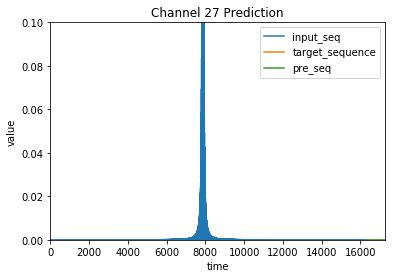

<Figure size 7200x720 with 0 Axes>

In [315]:
'''Visualization of predicted time series'''

in_seq = reg_data.ix[:,i][endix:endix+w]
tar_seq = reg_data.ix[:,i][endix+w:endix+w+p_w]
predicted_seq = predicted_seq.reshape((p_w))

d = {'time': reg_data.ix[:,i][endix+w:endix+w+p_w], 'values': predicted_seq}
df_pre = pd.DataFrame(data=d)
pre_seq = df_pre['values']

plt.plot(in_seq)
plt.plot(tar_seq)
plt.plot(tar_seq)


plt.ylim(top = 0.1)
plt.ylim(bottom=0)

plt.title('Channel 27 Prediction')
plt.ylabel('value')
plt.xlabel('time')
plt.legend(['input_seq', 'target_sequence', 'pre_seq'], loc='upper right')

axes = plt.gca()
axes.set_xlim([endix,endix+w+p_w])
fig_predict = plt.figure(figsize=(100,10))
fig_predict.savefig('predicted_sequence.png')
plt.show()    